# Combined Packing and Cracking

Packing is currently being defined as an alternate district having equal or superior compactness, while simultaneously decreasing MoV by at least 5% but not flipping.

In [81]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.spatial import distance_matrix
from tqdm import tqdm

In [82]:
DRIVE_PATH = "/Users/hanlin/Google Drive/CS+/Data/"
def full_path(filename):
    return DRIVE_PATH + filename

In [83]:
pd.options.mode.chained_assignment = None  # default='warn'

In [84]:
#Central, original dataset for all the VTDs, shouldn't need to change
og_data = gpd.read_file(full_path('NCabs_VTD'))

In [85]:
og_data.columns

Index(['VTD_num', 'GEOID10', 'ALAND10', 'AWATER10', 'COUNTY_FIP', 'loc_prec',
       'VTD_Name', 'total_pop', 'total_18+', 'EL08G_GV_D', 'EL08G_GV_R',
       'EL08G_GV_L', 'EL08G_GV_T', 'EL08G_USS_', 'EL08G_US_1', 'EL08G_US_2',
       'EL08G_US_3', 'EL08G_US_4', 'EL10G_USS_', 'EL10G_US_1', 'EL10G_US_2',
       'EL10G_US_3', 'EL10G_US_4', 'EL12G_GV_D', 'EL12G_GV_R', 'EL12G_GV_L',
       'EL12G_GV_W', 'EL12G_GV_1', 'EL12G_GV_T', 'EL14G_USS_', 'EL14G_US_1',
       'EL14G_US_2', 'EL14G_US_3', 'EL14G_US_4', 'Shape_Leng', 'Shape_Area',
       'EL12G_PR_D', 'EL12G_PR_R', 'EL12G_PR_L', 'EL12G_PR_W', 'EL12G_PR_1',
       'EL12G_PR_T', 'EL16G_PR_R', 'EL16G_PR_D', 'EL16G_PR_L', 'EL16G_PR_W',
       'EL16G_PR_T', 'EL16G_USS_', 'EL16G_US_1', 'EL16G_US_2', 'EL16G_US_3',
       'EL16G_GV_D', 'EL16G_GV_R', 'EL16G_GV_L', 'EL16G_GV_T', 'BPOP', 'nBPOP',
       'judge', 'newplan', 'oldplan', 'TOTPOP', 'NH_WHITE', 'NH_BLACK',
       'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP',
       '

### Packing Code Setup & Functions

In [138]:
def swap_map(dist_VTD_path, dist_shp_path, min_compact_pct=.95, pop_dev_tol=.02):
    #Intialize some dataframes
    dist_VTD_pair = pd.read_csv(dist_VTD_path, sep='\t', header=None).rename(columns={0:"VTD_num", 1:"district"})
    precincts = gpd.GeoDataFrame(og_data.merge(dist_VTD_pair, on='VTD_num'))
    districts = gpd.read_file(dist_shp_path) 
    districts.rename(columns={'District':'district'}, inplace=True)
    districts.index = districts.district #Now the index is literally 1 thru 13
    districts.index.name = None 
    
    #Do some renaming of cols
    precincts.rename(columns={"County":"COUNTY_FIPS", 'VTD_Key':'loc_prec', 'PL10AA_TOT':'total_pop',
                      'PL10VA_TOT':'total_18+', 'EL16G_PR_D':'total_dem', 'EL16G_PR_R':'total_rep',
                      'EL16G_PR_L':'total_lib', 'EL16G_PR_W':'writein', 'EL16G_PR_T':'total_vote',
                      'HVAP':'hispanic', 'WVAP':'white', 'BVAP':'african_am', 'AMINVAP':'am_indian_',
                      'ASIANVAP':'asian', 'NHPIVAP':'hawaii/pac', 'OTHERVAP':'other_race', 
                       '2MOREVAP':'2+races'}, inplace=True)
    #TODO: COULD DROP SOME OF THE ELECTORAL DATA, NOT NEEDED
            

    # Calculate the margin of victory in the OG districts; will be returned as part of the func.
    prec_slice = precincts[['total_dem', 'total_vote', 'total_rep', 'district']]
    og_MoV = prec_slice.groupby('district').sum()
    og_MoV['dem_perc'] = og_MoV['total_dem'] / og_MoV['total_vote']
    og_MoV['rep_perc'] = og_MoV['total_rep'] / og_MoV['total_vote']
    og_MoV['MoV'] = og_MoV['dem_perc'] - og_MoV['rep_perc'] #Dem is pos, rep is neg

    districts["area"] = districts.geometry.area
    districts["perimeter"] = districts.geometry.length
    districts["PolsbyPopper"] = (4 * math.pi)* (districts.area/(districts.perimeter**2))
    districts["ModSchwartz"] = ((2 * math.pi)*((districts.area/math.pi)**0.5))/districts.perimeter
    
    og_MoV = og_MoV.merge(districts, on='district') #We want the original compactness data too!

    precincts["neighbors"] = precincts.my_neighbo.str.split(", ")
    precincts_original = precincts.copy()

    all_dist_shapes = []   
    all_dist_comp = []
    for NUM in range(1, 14):
        ## RESET INITIAL DISTRICTS
        precincts = precincts_original.copy()

        ## GET INITIAL DISTRICT SHAPE
        dist_shape = precincts[precincts.district==NUM].unary_union
        
        ## Get initial district comp
        init_dist_comp = precincts.loc[precincts.district==NUM, "loc_prec"].tolist()
        #Calculate original schwartzberg measure
        orig_schwartz = districts.loc[NUM, "ModSchwartz"] 
        
        print(NUM, "schwrtz", orig_schwartz, "Mov", og_MoV.loc[og_MoV.district==NUM].iloc[0]['MoV'])

        #Keep track of changes to the evolving precinct (although I don't really use this)
        changelog = gpd.GeoDataFrame()

        i=0
        while True:
            i+= 1
            ### Every 50 iterations, print out the shape
            #if i % 50 == 0:
                #gpd.GeoSeries(dist_shape).plot()
                #plt.show()

            ### GET DISTRICT COPMOSIITON
            dist_comp = precincts.loc[precincts.district==NUM, "loc_prec"].tolist()

            ###NEIGHBORS
            neighbors = set()
            neighbor_list = precincts.loc[precincts.district==NUM, "neighbors"].tolist()
            for one_neighbor_list in neighbor_list:
                for item2 in one_neighbor_list:
                    neighbors.add(item2)
            neighbors = neighbors.difference(dist_comp)

            ###BOUNDARY PRECINCTS
            bound_prec = set()
            curr_dist = precincts.loc[precincts.district==NUM]
            for index, row in curr_dist.iterrows():
                if set(row.neighbors) & neighbors: #if a precinct has neighbors which aren't in the district, but rather neighbors:
                    bound_prec.add(row.loc_prec)

            ### CALCULATE DISTRICT-LEVEL STATISTICS 
            district_stats = precincts.groupby("district").sum()
            cds = district_stats.loc[NUM] 
            cds["geometry"] = dist_shape
            changelog = changelog.append(cds)

            ### CALCULATE CURRENT PARTISAN LEAN
            td = cds.at["total_dem"]
            tr = cds.at["total_rep"]
            tv = cds.at["total_vote"]
            tp = cds.at["total_pop"]
            curr_par = (td - tr)/tv #Positive is democratic lean, negative is republican

            ### CREATE WHAT-IF PRECINCT DF      
            whatif = precincts[precincts['loc_prec'].isin(neighbors|bound_prec)] #| is set union
            whatif.loc[whatif["loc_prec"].isin(neighbors), "is_neighbor"] = 1
            whatif.loc[whatif["loc_prec"].isin(bound_prec), "is_neighbor"] = -1

            whatif["total_pop"] = whatif.is_neighbor * whatif.total_pop
            whatif["total_dem"] = whatif.is_neighbor * whatif.total_dem
            whatif["total_vote"] = whatif.is_neighbor * whatif.total_vote
            whatif["total_rep"] = whatif.is_neighbor * whatif.total_rep

            ### CALCULATE HYPOTHETICAL LEANS AND POPULATION ONTO WHAT_IF GRAPH
            whatif["hyp_lean"] = (td + whatif.total_dem - tr - whatif.total_rep)/(tv + whatif.total_vote)
            whatif["hyp_pop"] = (tp + whatif.total_pop)

            ### SELECT ONLY THE PRECINCTS IN THE RIGHT POP DEV
            whatif = whatif.loc[(whatif.hyp_pop>733499 * (1-pop_dev_tol)) & (whatif.hyp_pop<733499*(1+pop_dev_tol))]
            #print(whatif.shape)

            ### SORT TO PICK BIGGEST PARTISAN LEAN CHANGE
            whatif["lean_chg"] = abs(curr_par) - abs(whatif.hyp_lean) #Must take abs values
            lean_chg = abs(curr_par) - abs(whatif.hyp_lean)
            whatif.sort_values(by="lean_chg", inplace=True, ascending=False) #Sort from highest lean_chg to lowest


            ### START DISSOLVING, CHECK COMPACTNESS AND CONTIGUITY
            no_better_sol = True
            for index, row in whatif.iterrows():
                if row.lean_chg < 0: #If partisan lean only gets worse
                    no_better_sol = True
                    break
                if row.is_neighbor == -1: #i.e. it's a boundary precinct
                    new_shape = dist_shape.difference(row.geometry)
                else: #otherwise it's a neighboring precinct
                    new_shape = dist_shape.union(row.geometry) 
                new_schwartz = ((2 * math.pi)*((new_shape.area/math.pi)**0.5))/new_shape.length
                #Remove higher bound on compactness — it's excellent if it exceeds!
                if (new_schwartz > orig_schwartz * min_compact_pct):
                    if (str(type(new_shape)) == "<class 'shapely.geometry.polygon.Polygon'>"): #Check multipolygon contiguity
                        if len(new_shape.interiors) == 0: #Check for holes
                            no_better_sol = False
                            dist_shape = new_shape
                            if row.is_neighbor == -1:
                                precincts.loc[precincts.loc_prec == row.loc_prec, "district"] =  -1
                                #print("remove" + row.loc_prec + " Partisan: " + str(row.lean_chg))
                            else:
                                precincts.loc[precincts.loc_prec == row.loc_prec, "district"] = NUM
                                #print("add" + row.loc_prec + " Partisan: " + str(row.lean_chg))
                            break

            if no_better_sol==True:
                print("No more valid additions after ", i, "iterations, cmpct ", new_schwartz, "MoV", curr_par)
                break
                
            if i % 10 == 0:
                print(i, "iterations, cmpct ", new_schwartz, "Mov", curr_par)

        ### ADD THE FINAL SWAPPED DISTRICT TO A DF
        district_stats = precincts.groupby("district").sum()
        cds = district_stats.loc[NUM]
        cds["geometry"] = dist_shape
        all_dist_shapes.append(cds)
        all_dist_comp.append(init_dist_comp)
        
        
        
    gmandered_dict, dem_locs, rep_locs = calc_pack_score(all_dist_shapes, og_MoV, districts, all_dist_comp)
    return gmandered_dict, dem_locs, rep_locs

In [130]:
def calc_pack_score(ret, og_stats, districts, all_dist_comp, graph=False):
    dem_locs = []
    rep_locs = []
    
    # Transform our finalized districts into a GeoDF and add the extra columns
    gdf = gpd.GeoDataFrame(ret)
    gdf["district"] = gdf.index
    gdf["area"] = gdf.geometry.area
    gdf["perimeter"] = gdf.geometry.length
    gdf["PolsbyPopper"] = (4 * math.pi)* (gdf.area/(gdf.perimeter**2))
    gdf["ModSchwartz"] = ((2 * math.pi)*((gdf.area/math.pi)**0.5))/gdf.perimeter
    gdf['dem_pct'] = gdf['total_dem']/gdf['total_vote']
    gdf['rep_pct'] = gdf['total_rep']/gdf['total_vote']
    gdf['MoV'] = gdf['dem_pct'] - gdf['rep_pct']

    og_stats.index = og_stats.district
    og_stats.index.name = None

    # Calculate number of packed voters
    rep_packed = 0
    dem_packed = 0
    packed_voters = 0
    for index, row in gdf.iterrows():
        if ((row['ModSchwartz'] >= og_stats.loc[index, 'ModSchwartz']) and (np.sign(row['MoV']) == np.sign(og_stats.loc[index, 'MoV'])) and (np.abs(row['MoV']) <= np.abs(og_stats.loc[index, 'MoV'])-0.05)):
            print(index, "satisfied packing reqs")
            if(row['MoV'] > 0):
                dem_packed += row['total_dem']
                packed_voters += row['total_dem']
                dem_locs += all_dist_comp[index-1]
            else:
                rep_packed += row['total_rep']
                packed_voters += row['total_rep']
                rep_locs += all_dist_comp[index-1]
    print('Packed Voters:', packed_voters)
    if graph==True:
        #Plot New District Outlines
        base = districts.plot(figsize=(18, 16), edgecolor="black", color="white", linewidth =1)
        gdf.plot(ax=base, column = "district", cmap="tab20", alpha=0.5, edgecolor="grey") #Using votes as a proxy for dist

        #Plot New  District Partisanness
        gdf["rep_prop"] = gdf["total_rep"]/gdf["total_vote"]
        base = districts.plot(figsize=(18, 16), edgecolor="black", color="black", linewidth =1)
        gdf.plot(ax=base, column = "rep_prop", cmap="bwr", edgecolor="grey", legend=True, vmin=0, vmax=1)
        
    gmandered_dict = {'total_packed':packed_voters, 'packed_dems':dem_packed, 'packed_reps':rep_packed}
    return gmandered_dict, dem_locs, rep_locs

### Cracking Code Setup Function

In [88]:
#og_data is the same as DF in this case.
### Discard unnecessary data, keep only HoR voting data from 2016
def merge_shp_with_election(dist_VTD_path):
    final = og_data.drop(columns=['GEOID10', 'ALAND10', 'AWATER10', 'COUNTY_FIP', 'VTD_Name', 'EL08G_GV_D', 
                             'EL08G_GV_R', 'EL08G_GV_L', 'EL08G_GV_T', 'EL08G_USS_', 'EL08G_US_1', 'EL08G_US_2', 
                             'EL08G_US_3', 'EL08G_US_4', 'EL10G_USS_', 'EL10G_US_1', 'EL10G_US_2', 'EL10G_US_3', 
                             'EL10G_US_4', 'EL12G_GV_D', 'EL12G_GV_R', 'EL12G_GV_L','EL12G_GV_W', 'EL12G_GV_1', 
                             'EL12G_GV_T', 'EL14G_USS_', 'EL14G_US_1','EL14G_US_2', 'EL14G_US_3', 'EL14G_US_4', 
                             'Shape_Leng', 'Shape_Area', 'EL12G_PR_D', 'EL12G_PR_R', 'EL12G_PR_L', 'EL12G_PR_W', 
                             'EL12G_PR_1', 'EL12G_PR_T', 'EL16G_PR_R', 'EL16G_PR_D', 'EL16G_PR_L', 'EL16G_PR_W',
                             'EL16G_PR_T', 'EL16G_USS_', 'EL16G_US_1', 'EL16G_US_2', 'EL16G_US_3', 'EL16G_GV_D', 
                             'EL16G_GV_R', 'EL16G_GV_L', 'EL16G_GV_T', 'BPOP', 'nBPOP', 'judge', 'newplan', 
                             'oldplan', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 
                             'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 
                             'H_OTHER', 'H_2MORE', 'VAP', 'hor12_dem', 'hor12_rep', 'hor12_othe'])

    ### Match column names to NC state map naming conventions
    final.rename(columns={'hor16_dem':'total_dem', 'hor16_rep':'total_rep', 'hor16_othe':'total_other'}, inplace=True)

    final['total_vote'] = final['total_dem'] + final['total_rep'] + final['total_other']

    ### Add judges' districts
    assignment = pd.read_csv(dist_VTD_path, sep='\t', header=None)
    assignment = assignment.rename(columns={0:'VTD_num', 1:'district'})

    final2 = final.merge(assignment, on='VTD_num')
    final2.drop(columns={'VTD_num'}, inplace=True)
    return final2

### Cracking Code Main Functions

In [89]:
### Add 'dem_dist' column to amap that =1 if the precinct belongs to a democratic district and =0 if the precinct
### belongs to a republican district

def calc_dist(amap):
    amap['dem_dist'] = 0
    districts = amap.groupby('district').sum()
    districts['dem_dist'] = 0
    districts.loc[districts.total_dem > districts.total_rep, 'dem_dist'] = 1
    districts.reset_index(inplace=True)
    dem_districts = districts.loc[districts.dem_dist == 1, 'district'].to_numpy()
    amap.loc[amap.district.isin(dem_districts), 'dem_dist'] = 1
    amap['rep_dist'] = 1 - amap['dem_dist']

In [90]:
def calc_wasted_votes(amap):
    amap['wasted_rep'] = amap.dem_dist * amap.total_rep # 'wasted_rep' are republicans who are in a democratic district
    amap['wasted_dem'] = amap.rep_dist * amap.total_dem # 'wasted_dem' are democrats who are in a republican district

In [91]:
def coord_lister(geom):
    coords = list(geom.coords)
    return (coords)

In [92]:
def calc_dist_matrix(amap):
    amap['centroid'] = amap.geometry.centroid
    coordinates = amap.centroid.apply(coord_lister)
    coordinates = coordinates.tolist()
    coordinates = [coordinates[i][0] for i in range(len(coordinates))]
    df = pd.DataFrame(distance_matrix(coordinates, coordinates))
    df.columns = amap.loc_prec
    last_col = amap.columns[-2]
    concated = pd.concat([amap, df], axis=1)
    concated.insert(0, "dummy", 0)
    
    return concated, last_col

In [93]:
def create_hyp_districts(loc_prec_df, concated, ideal_pop, last_col, dissolve=False, test=False):
    hyp_list = [] # list of hypothetical districts
    units_w_cracked_dems = set()
    units_w_cracked_reps = set()
    
    for index, row in tqdm(loc_prec_df.iterrows()): # generate a hypothetical district for each precinct/VTD/unit
        concated = concated.sort_values(by=row.loc_prec) # sort by how close each unit is to the given one
        concated["cum_sum"] = concated.total_pop.cumsum() # calculate population of a "district" containing current unit and all units closer than it to the given unit
        hyp = concated.loc[concated.cum_sum <= ideal_pop].copy() # hypothetical district is the largest district whose population is under ideal_pop
        hyp.drop("centroid", inplace=True, axis=1) # drop 'centroid' column
        hyp = hyp.loc[:,"dummy":last_col] # don't include the distance matrix in hyp
        
        if test == True:
            print(row.loc_prec)
        
        if hyp.total_dem.sum() > hyp.total_rep.sum(): # dem wins
            hyp['new_dem_dist'] = 1
            hyp['new_rep_dist'] = 0
            # loc_precs previously in republican districts have cracked democratic voters
            cracked = hyp.loc[hyp.rep_dist == 1, 'loc_prec']
            if test == True: 
                print('loc_precs w cracked dems:', len(cracked))
                print('democrats cracked in hyp:', hyp['wasted_dem'].sum())
            units_w_cracked_dems.update(cracked)
        else: # rep wins
            # loc_precs previously in democratic districts have cracked republican voters
            hyp['new_dem_dist'] = 0
            hyp['new_rep_dist'] = 1
            cracked = hyp.loc[hyp.dem_dist == 1, 'loc_prec']
            if test == True:
                print('loc_precs w cracked reps:', len(cracked))
                print('republicans cracked in hyp:', hyp['wasted_rep'].sum())
            units_w_cracked_reps.update(cracked)
        
#         if dissolve==True:
#             hyp = hyp.dissolve(by='dummy', aggfunc='sum')
#         else:
#             hyp = hyp.groupby("dummy").sum() # make hyp a single row 

#         if hyp.total_dem[0] > hyp.total_rep[0]: #dem wins
#             hyp["new_dem_win"] = 1
#             hyp['cracked_dem'] = hyp.wasted_dem # record democrats who belonged to republican districts in the original map
#         else: #rep wins
#             hyp["new_dem_win"] = 0
#             hyp['cracked_rep'] = hyp.wasted_rep # record republicans who belonged to democratic districts in the original map        
       
        hyp["seed"] = row.loc_prec # hyp.seed = the given unit the hypothetical district was generated around
        hyp.reset_index(inplace=True, drop=True)
        hyp_list.append(hyp)
        if test == True:
            print('hyp_list length:', len(hyp_list))
            print()

    return units_w_cracked_dems, units_w_cracked_reps, hyp_list

In [94]:
def calc_cracked_pop(amap, units_w_cracked_dems, units_w_cracked_reps):
    cracked_dems = amap.loc[amap.loc_prec.isin(units_w_cracked_dems), 'wasted_dem'].sum()
    cracked_reps = amap.loc[amap.loc_prec.isin(units_w_cracked_reps), 'wasted_rep'].sum()
    total_cracked = cracked_dems + cracked_reps
    return total_cracked, cracked_dems, cracked_reps

In [95]:
def check_cracked(amap, ideal_pop, dissolve=False, test=False):
    calc_dist(amap)
    calc_wasted_votes(amap)
    concated, last_col = calc_dist_matrix(amap)
    units_w_cracked_dems, units_w_cracked_reps, hyp_list = create_hyp_districts(amap, concated, ideal_pop, last_col, dissolve, test)
    total_cracked, cracked_dems, cracked_reps = calc_cracked_pop(amap, units_w_cracked_dems, units_w_cracked_reps)
    
    print('total num people cracked:', total_cracked)
    print('num democrats cracked:', cracked_dems)
    print('num republicans cracked:', cracked_reps)
    print()
    gmandered_dict = {'total_cracked':total_cracked, 'cracked_dems':cracked_dems, 'cracked_reps':cracked_reps}
    return gmandered_dict, units_w_cracked_dems, units_w_cracked_reps

In [96]:
def calc_ideal_pop(amap, num):
    ideal_pop = amap['total_pop'].sum() / num
    print(ideal_pop)
    return ideal_pop

### Get Total Score

In [137]:
def get_total_score(dist_VTD_path, dist_shp_path):
    merged_map = merge_shp_with_election(dist_VTD_path)
    ideal_pop = calc_ideal_pop(merged_map, 13)
    cracked_dict, cracked_dems, cracked_reps = check_cracked(merged_map, ideal_pop)
    packed_dict, dem_locs, rep_locs = swap_map(dist_VTD_path, dist_shp_path, 1, .02) #Can change these parmeters if wished
    total_gmandered = cracked_dict['total_cracked'] + packed_dict['total_packed']
    total_dems = cracked_dict['cracked_dems'] + packed_dict['packed_dems']
    total_reps = cracked_dict['cracked_reps'] + packed_dict['packed_reps']
    print('tot gman', total_gmandered, 'tot dem', total_dems, 'tot reps', total_reps)
    return cracked_dict, packed_dict, total_gmandered, total_dems, total_reps, cracked_dems, cracked_reps, dem_locs, rep_locs

### Get Initial Feeling for which maps do best on the metric

In [98]:
#get_total_score(full_path('code_data_NC_NCAbs_2016.txt'), full_path('nc_district_shapefiles'))

In [99]:
#get_total_score(full_path('code_data_NC_NCAbs_2012.txt'), full_path('2012_NC_shapefiles'))

In [100]:
#get_total_score(full_path('code_data_NC_NCAbs_Judges.txt'), full_path('NC_judges_shapefiles'))

In [101]:
#get_total_score(full_path('acr_VTD.txt'), full_path('acr_shapefiles'))

### Investigate Why Judges Does Better than ACR

In [139]:
def generate_heat_maps(dist_shp_path):
    og_data['cracked_dem'] = 0
    og_data['cracked_rep'] = 0
    og_data.loc[og_data.loc_prec.isin(cracked_dems), 'cracked_dem'] = 1
    og_data.loc[og_data.loc_prec.isin(cracked_reps), 'cracked_rep'] = 1
    og_data['packed_dem'] = 0
    og_data['packed_rep'] = 0
    og_data.loc[og_data.loc_prec.isin(dem_locs), 'packed_dem'] = 1
    og_data.loc[og_data.loc_prec.isin(rep_locs), 'packed_rep'] = 1
    
    districts = gpd.read_file(dist_shp_path) 
    districts.rename(columns={'District':'district'}, inplace=True)
    districts.index = districts.district #Now the index is literally 1 thru 13
    districts.index.name = None 
    
    base = og_data.plot(column='cracked_dem', cmap="Blues", legend=True,  figsize=(18, 16), vmin=0, vmax=1,legend_kwds={'shrink': 0.3})
    districts.plot(ax=base, edgecolor='black', linewidth=2, facecolor='none')
    plt.title('Dem Crack')
    
    base = og_data.plot(column='packed_dem', cmap="Blues", legend=True,  figsize=(18, 16), vmin=0, vmax=1,legend_kwds={'shrink': 0.3})
    districts.plot(ax=base, edgecolor='black', linewidth=2, facecolor='none')
    plt.title('Dem Pack')
    
    base = og_data.plot(column='cracked_rep', cmap="Reds", legend=True,  figsize=(18, 16), vmin=0, vmax=1,legend_kwds={'shrink': 0.3})
    districts.plot(ax=base, edgecolor='black', linewidth=2, facecolor='none')
    plt.title('Rep Crack')
    
    base = og_data.plot(column='packed_rep', cmap="Reds", legend=True,  figsize=(18, 16), vmin=0, vmax=1,legend_kwds={'shrink': 0.3})
    districts.plot(ax=base, edgecolor='black', linewidth=2, facecolor='none')
    plt.title('Rep Pack')
    

In [140]:
jud_crk, jud_pk, d, e, f, cracked_dems, cracked_reps, dem_locs, rep_locs = get_total_score(full_path('code_data_NC_NCAbs_Judges.txt'), full_path('NC_judges_shapefiles'))

733498.6923076923


2690it [02:08, 20.93it/s]


total num people cracked: 1290819
num democrats cracked: 854714
num republicans cracked: 436105

1 schwrtz 0.7894183899881992 Mov 0.23898191119700196
No more valid additions after  1 iterations, cmpct  0.7780455678322998 MoV 0.23898191119700196
2 schwrtz 0.5152103966672488 Mov -0.1431143637102864
No more valid additions after  8 iterations, cmpct  0.5182098825448458 MoV -0.1374248538252491
3 schwrtz 0.481869692948199 Mov -0.22331290045211216
10 iterations, cmpct  0.4874099461399515 Mov -0.19545983990483506
20 iterations, cmpct  0.48462532570741534 Mov -0.1696923208045683
No more valid additions after  28 iterations, cmpct  0.46966986493665963 MoV -0.14704672025458834
4 schwrtz 0.5292760291689591 Mov -0.41809504815089177
10 iterations, cmpct  0.5328238476016272 Mov -0.3926168530648755
20 iterations, cmpct  0.5318074639510492 Mov -0.3730390926813934
30 iterations, cmpct  0.5372012867360801 Mov -0.36194530614040876
No more valid additions after  38 iterations, cmpct  0.5223480009536583 Mo

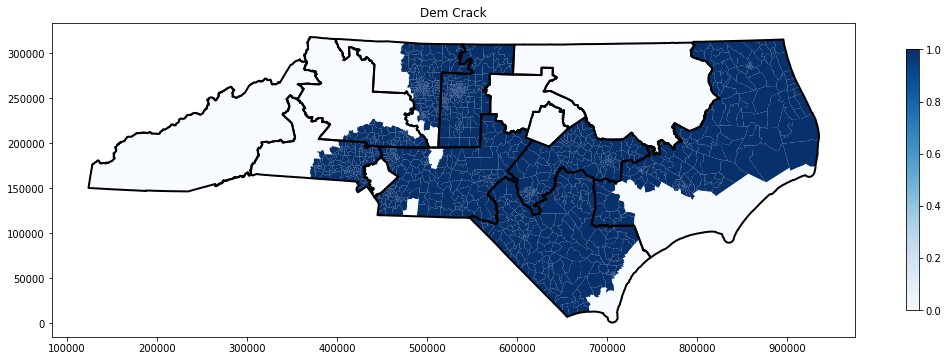

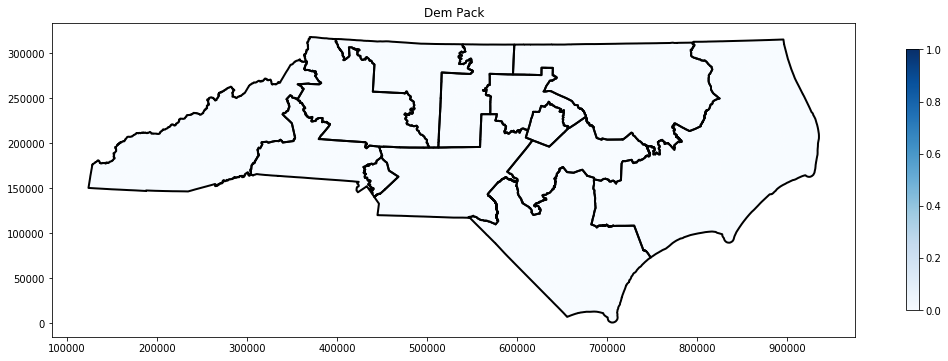

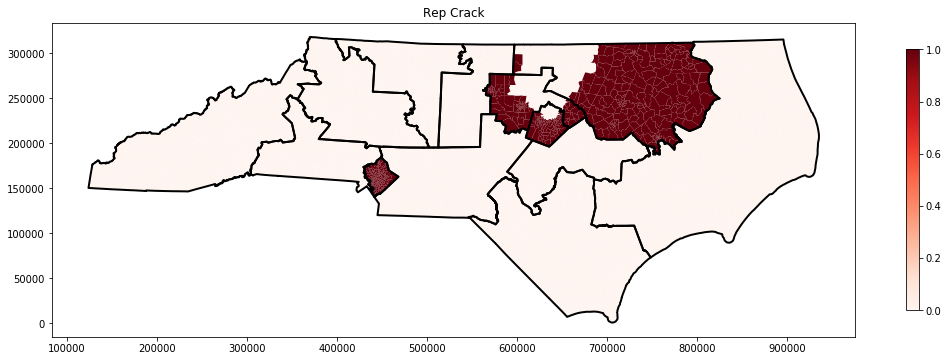

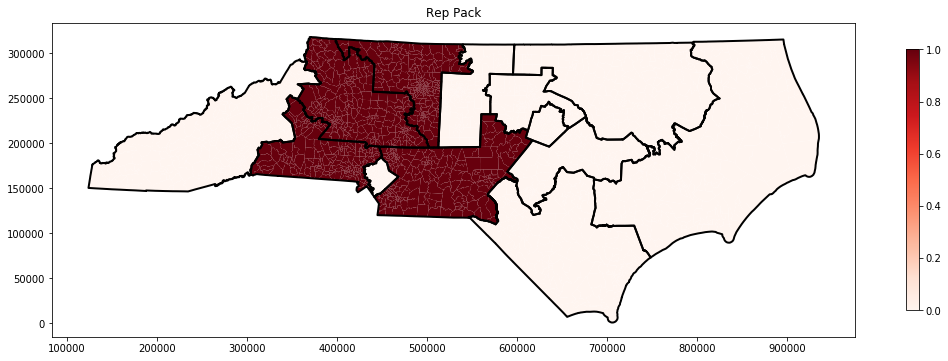

In [141]:
generate_heat_maps(full_path('NC_judges_shapefiles'))

In [126]:
jud_crk, jud_pk, d, e, f, cracked_dems, cracked_reps, dem_locs, rep_locs = get_total_score(full_path('acr_VTD.txt'), full_path('acr_shapefiles'))

733498.6923076923


1929it [01:23, 23.14it/s]


KeyboardInterrupt: 

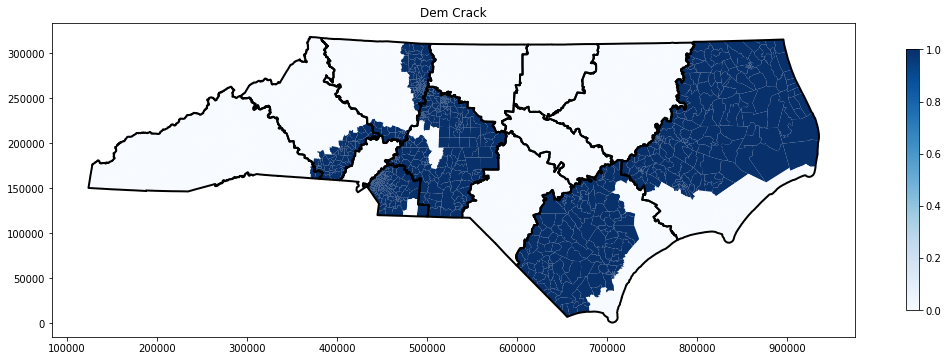

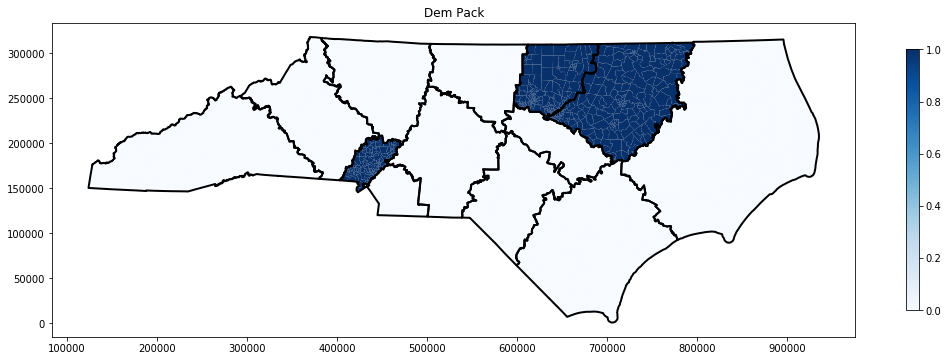

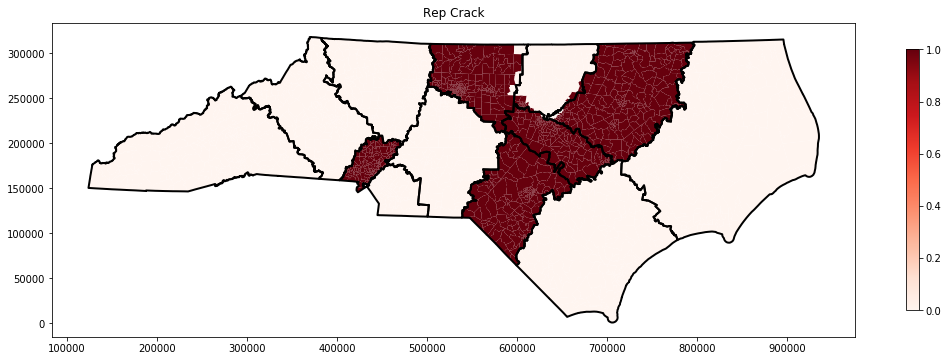

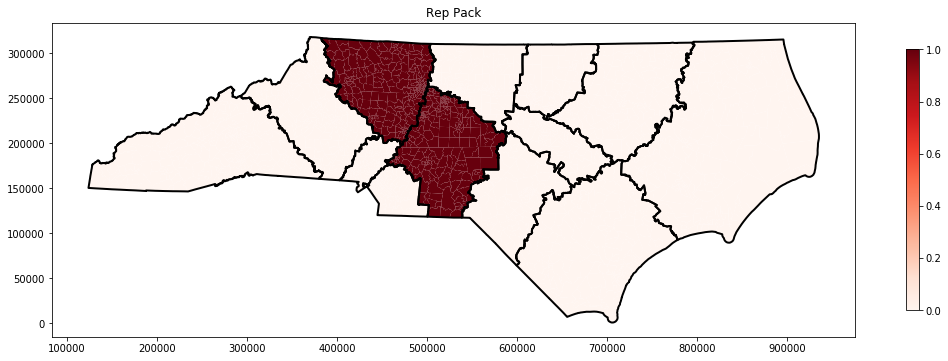

In [122]:
generate_heat_maps(full_path('acr_shapefiles'))

Conclusion: Personally, I am not sure how reliable our metrics are. For example, I am surprised that in the Judges map for republican packing, it was able to find 4 republican districts could be even less packed. In fact, both the judges and the ACR maps should be quite "good," so I am surprised that in both of these maps, it was able to supposedly locate instances of packing. This makes me think I should up the compactness measure—perhaps it needs to increase by 5% to identify packing. But therein lies the problem—we could tweak these metrics as much as we want. We could increase the packing MoV threshold, etc. etc. So personally, I am not really inclined to take this approach further, but who nkows

### Plot District Partisanness, shall we?

In [145]:
def plot_dist_partisaness(finaldf):
#Expensive operation
    districts = finaldf.dissolve(by="district", aggfunc="sum")
    districts["rep_prop"] = (districts["EL16G_PR_R"]/districts["EL16G_PR_T"]).round(3) #for total rep & total vote
    districts['coords'] = districts['geometry'].apply(lambda x: x.representative_point().coords[:])
    districts['coords'] = [coords[0] for coords in districts['coords']]
    districts.plot(figsize=(18, 16),
               column="rep_prop", cmap="coolwarm", legend=True, vmin=0, vmax=1, edgecolor="black")
    plt.title("Rep Vote Percentage Per District")
    for idx, row in districts.iterrows():
        plt.annotate(s=row['rep_prop'], xy=row['coords'],
                     horizontalalignment='center')
    print(calc_eff_gap(finaldf))

In [146]:
dist_VTD_pair = pd.read_csv(full_path('code_data_NC_NCAbs_Judges.txt'), sep='\t', header=None).rename(columns={0:"VTD_num", 1:"district"})
precincts = gpd.GeoDataFrame(og_data.merge(dist_VTD_pair, on='VTD_num'))
plot_dist_partisaness(precincts)

NameError: name 'calc_eff_gap' is not defined

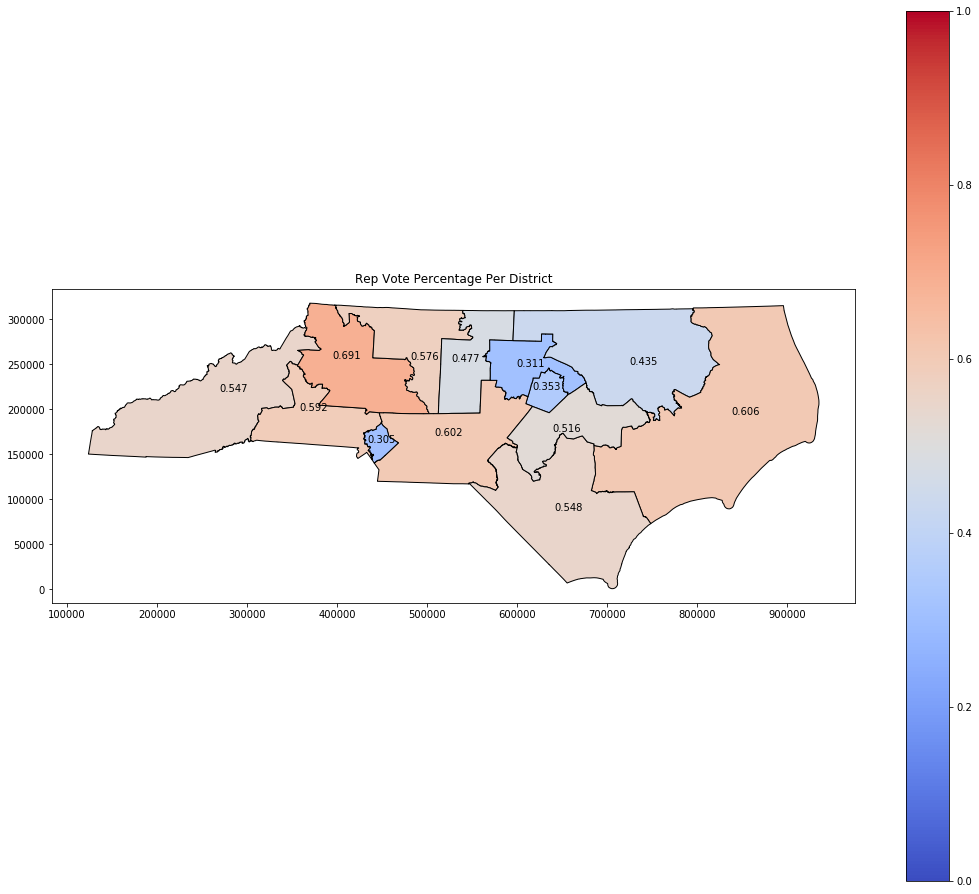

In [147]:
plot_dist_partisaness(precincts)

NameError: name 'calc_eff_gap' is not defined

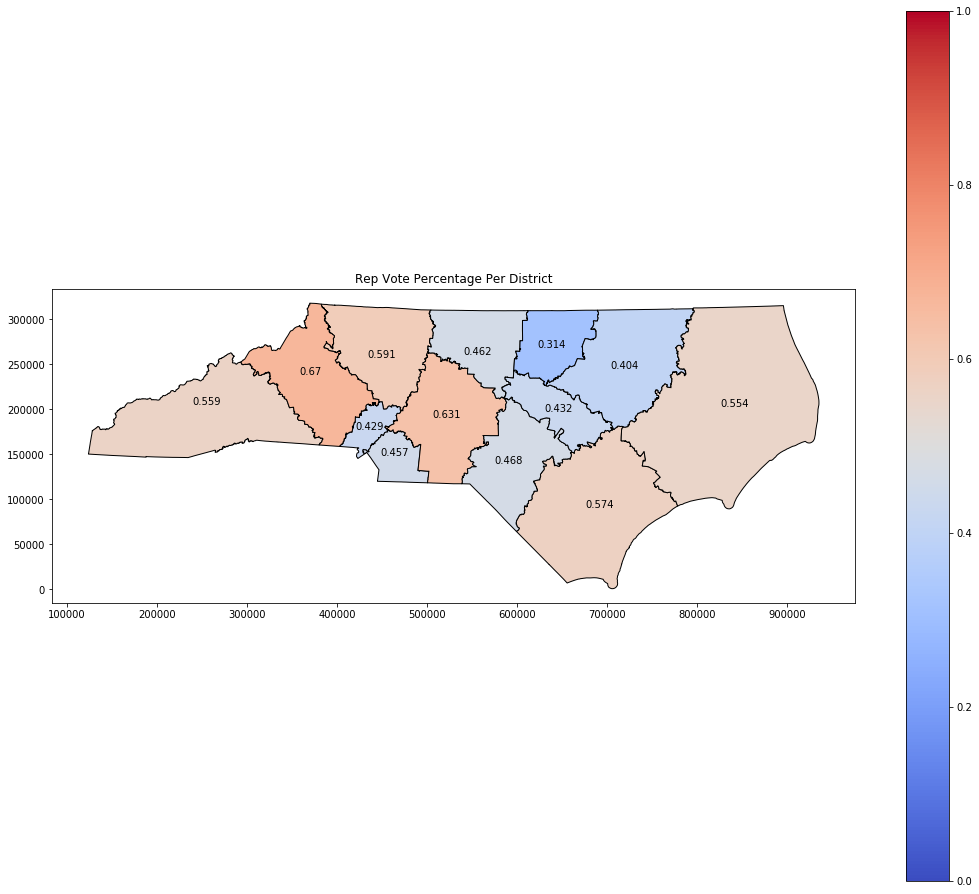

In [148]:
dist_VTD_pair = pd.read_csv(full_path('acr_VTD.txt'), sep='\t', header=None).rename(columns={0:"VTD_num", 1:"district"})
precincts = gpd.GeoDataFrame(og_data.merge(dist_VTD_pair, on='VTD_num'))
plot_dist_partisaness(precincts)